In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from bubbly.bubbly import bubbleplot 
from tqdm import tqdm
from geopy.geocoders import Nominatim
import plotly.io as pio
from plotly.offline import iplot

In [38]:
data = pd.read_csv('all_v2.csv')

In [39]:
data.columns

Index(['price', 'date', 'time', 'geo_lat', 'geo_lon', 'region',
       'building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area',
       'object_type'],
      dtype='object')

In [40]:
data['region'].nunique()

84

In [41]:
data['building_type'].nunique()

6

# Price 
В столбце Цена есть 356 значений с отрицательной стоимостью жилья, что в контексте данных не соотносится с логикой задачи. Поэтому удалим дубликаты и объекты недвижимости с отрицательной ценой.

Значение цены очень большое, при линейной регрессии будут искуственно завышать коэффициенты. Нужна нормализация (либо логарифмирование)

In [42]:
data.agg({"price": ["min", "max", "mean"],
           "area": ["min", "max", "median", "mean"]})

,price,area
max,2.147484e+09,7856.000000
mean,4.422029e+06,53.918249
median,NaN,48.020000
min,-2.144967e+09,0.070000


In [43]:
sum(data['price']<0)

365

In [44]:
data = data[data['price'] > 0]
data = data.drop_duplicates()

In [45]:
data.shape

(5475095, 13)

# Region 
всего в данных у нас присутствует 84 региона. 

По некоторым регионам данных очень много (более 1 млн записей), а по нектороым - совсем мало. 
Для первичного анализа посмотрим на средние значения по регионам с кол-вом записей больше и меньше медианы. 

Т.е. логически это можно разделить на 2 типа регионов:

1 - по которым данных не много

2 - по которым данных много


In [46]:
region_count = data.groupby('region')['price'].count()
region_count = region_count.reset_index()
region_count = region_count.rename(columns={"price": "cnt"})

In [47]:
region_count.sort_values(by = ['cnt']).head(10)

,region,cnt
83,61888,5
6,1901,12
40,4963,65
1,69,77
82,16705,139
77,13098,256
81,14880,357
80,14368,593
78,13913,735
43,5178,745


In [48]:
region_count.sort_values(by = ['cnt']).tail(10)

,region,cnt
31,3991,141607
45,5282,155635
28,3230,222627
24,2922,230493
54,6171,237170
0,3,439078
14,2661,461564
2,81,500221
18,2843,637124
70,9654,1048966


In [49]:
print(region_count[region_count['cnt'] == region_count['cnt'].min()])
print(region_count[region_count['cnt'] == region_count['cnt'].max()])

    region  cnt
83   61888    5
    region      cnt
70    9654  1048966


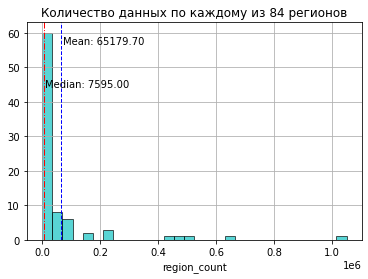

In [50]:
plt.hist(region_count['cnt'], bins = 30, color='c', edgecolor='k', alpha=0.65)
plt.axvline(region_count['cnt'].mean(), color='b', linestyle='dashed', linewidth=1)
plt.axvline(region_count['cnt'].median(), color='r', linestyle='dashdot', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(region_count['cnt'].mean()*1.1, max_ylim*0.9,
         'Mean: {:.2f}'.format(region_count['cnt'].mean()))
plt.text(region_count['cnt'].median()*1.1, max_ylim*0.7,
         'Median: {:.2f}'.format(region_count['cnt'].median()))
plt.xlabel('region_count')
plt.title('Количество данных по каждому из 84 регионов')
plt.grid()
plt.show()

In [51]:
region_info = data.groupby('region').agg({'price': ['mean', 'count'],
                            'area': ['mean'],
                            'levels': ['mean']})

In [52]:
region_info = region_info.reset_index()

In [53]:
region_info

region         price               area     levels
                   mean   count       mean       mean
0       3  1.314751e+07  439078  58.096136  16.299589
1      69  2.088702e+06      77  49.567532   6.285714
2      81  4.766510e+06  500221  51.736106  12.741362
3     821  2.514267e+06    2519  59.409960  11.133783
4    1010  2.335856e+06   48396  49.162687   8.942578
..    ...           ...     ...        ...        ...
79  13919  2.578329e+06    9912  66.456601   5.918483
80  14368  2.283814e+06     593  51.823103   6.752108
81  14880  3.941868e+06     357  56.026246   6.002801
82  16705  2.939970e+06     139  50.328777   5.582734
83  61888  3.820000e+06       5  54.420000   3.600000

[84 rows x 5 columns]

In [54]:
split_by_median = region_count['cnt'].median()

In [55]:
region_small_info = region_info[region_info['price','count'] < split_by_median]
region_big_info = region_info[region_info['price','count'] > split_by_median]

In [56]:
region_small_info

region         price              area     levels
                   mean count        mean       mean
1      69  2.088702e+06    77   49.567532   6.285714
3     821  2.514267e+06  2519   59.409960  11.133783
5    1491  2.713341e+06  3857   54.641854  14.597874
6    1901  2.716667e+06    12   57.225000   5.250000
10   2484  4.272074e+06  5425   60.701003  10.164608
12   2594  2.478564e+06  4837   48.587250  11.155675
16   2806  2.519476e+06  2151   54.112455  10.569503
17   2814  2.509104e+06  1125   54.746524   9.622222
22   2885  3.687045e+06  2464   97.213129   6.142045
27   3153  2.329425e+06  5573   51.436797  13.305401
33   4086  3.971548e+06  2212   55.042735   9.509042
34   4189  2.726112e+06  5589   53.125037   6.707103
35   4240  2.557007e+06  2405   53.140915  12.764241
36   4249  2.339217e+06  2760   52.996341   9.579348
37   4374  2.484351e+06  2795   52.804608   8.979249
39   4695  2.811132e+06  7496   54.202114   9.572972
40   4963  2.388952e+06    65   48.368308   5.446154
42   5143  3.087127e+06  3026   53.457436  10.531395
43   5178  3.530563e+06   745   56.166658   4.617450
48   5703  1.750560e+06  1210   48.543777   6.702479
49   5736  2.171159e+06   896   51.686384   6.568080
51   5794  2.303425e+06  3208   54.390493   8.639339
53   5993  2.773186e+06  5364   50.953322  12.499814
55   6309  2.284870e+06  1248   51.274631   4.619391
56   6543  3.789349e+06  3966   53.005096   9.035804
58   6937  5.230100e+06  4700   58.087638   8.597872
59   7121  2.735978e+06  2086   56.952502  10.460211
61   7873  5.595442e+06  2241   60.620937   6.883088
63   7929  4.620422e+06  2167   54.947167   8.583756
65   8509  2.008443e+06  2785   60.829813   5.143627
66   8640  2.868825e+06  1596   54.397180   8.438596
67   8894  2.255853e+06  2202   54.087189   9.746594
72  10201  3.299663e+06  2554   54.278935   9.533673
73  10582  2.931846e+06  1787   62.587571   8.989927
75  11416  1.887369e+06  5243   44.407461   5.696357
76  11991  2.553575e+06  6381   58.810451   6.555399
77  13098  3.195527e+06   256   57.317969   4.812500
78  13913  1.242363e+07   735  133.694354   7.365986
80  14368  2.283814e+06   593   51.823103   6.752108
81  14880  3.941868e+06   357   56.026246   6.002801
82  16705  2.939970e+06   139   50.328777   5.582734
83  61888  3.820000e+06     5   54.420000   3.600000

/Users/karinahanova/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/karinahanova/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


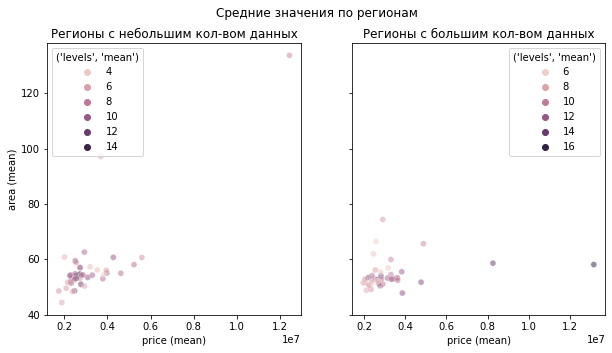

In [57]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle("Средние значения по регионам")
sns.scatterplot(region_small_info['price','mean'], region_info['area','mean'], 
                     alpha = 0.5, hue = region_small_info['levels','mean'], ax=ax1)

#for line in range(0,region_small_info.shape[0]):
   #  axs[0].text(region_small_info['price','mean'].iloc[line], 
           #  region_small_info['area','mean'].iloc[line], 
           #  region_small_info['region'].iloc[line], 
           #  horizontalalignment='center', 
           #  size='medium', color='black', weight='semibold')
ax1.set(xlabel='price (mean)', ylabel='area (mean)')
ax1.set_title('Регионы с небольшим кол-вом данных')


sns.scatterplot(region_big_info['price','mean'], region_big_info['area','mean'], 
                alpha = 0.5, hue = region_big_info['levels','mean'], ax=ax2)


ax2.set(xlabel='price (mean)', ylabel='area (mean)')
ax2.set_title('Регионы с большим кол-вом данных')
plt.show()

Из этих графиков мы видим, что в регионах с небольшим кол-вом данных зависимость цены от площади более линейная: т.е. с увечничением площади, растет и цена, т.е. (если прям стого спредположить) стоимость 1го квадратного метра дороже. 
В регионах же с большим кол-вом данных наблюдается, что цена за квадратный метр более "стабильная" (т.к. данные сконцентрированы в одном месте). 
Также можно обратить внимание на среднее кол-во этажей. В регионах с небольшим кол-вом данных - более высокие дома.

Из этого можно сделать предположение, что данные с левого графика собраны с центральных точек России (больших городов как Мск и Спб), а данные с правого графика - отражают положение дел в регионах России. 
Проверим это tupoe предположение.

In [58]:
data.shape

(5475095, 13)

In [59]:
region_big_info.head()

region         price               area     levels
                  mean   count       mean       mean
0      3  1.314751e+07  439078  58.096136  16.299589
2     81  4.766510e+06  500221  51.736106  12.741362
4   1010  2.335856e+06   48396  49.162687   8.942578
7   2072  2.820893e+06   63108  53.990464  13.854297
8   2328  3.306817e+06    8159  54.492411   9.886996

In [60]:
data_region_big_info = data.loc[data['region'].isin(region_big_info['region'].values)]
data_region_small_info = data.loc[data['region'].isin(region_small_info['region'].values)]

In [61]:
data_region_big_info.shape

(5368243, 13)

In [62]:
data_region_small_info.shape

(106852, 13)

In [63]:
data_region_big_info.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


/Users/karinahanova/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
No handles with labels found to put in legend.


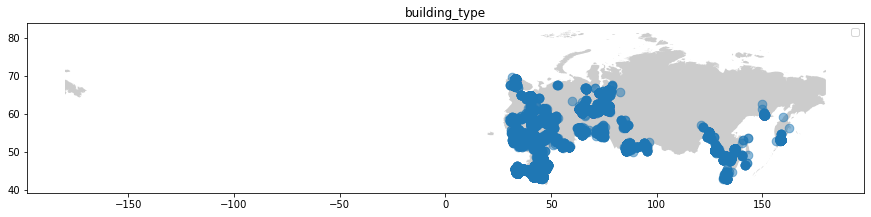

In [327]:
russia_map = gpd.read_file('/Users/karinahanova/Desktop/MTS.Teta/geo_practice/russia_shape_file/RUS_adm0.shp')


geometry = [Point(xy) for xy in zip (data_region_small_info['geo_lon'],data_region_small_info['geo_lat'])]

crs = {'init': 'epsg:4326'}
geo_data = gpd.GeoDataFrame(data_region_small_info, crs=crs, geometry=geometry)
geo_data.head()

fig,ax = plt.subplots(figsize = (15,15))
russia_map.plot(ax=ax, alpha = 0.4, color ='grey')
geo_data.geometry.plot(ax = ax, alpha=.5, markersize = 75 )
#geo_data[geo_data['building_type']==2].geometry.plot(marker='o', color = 'red', ax = ax, label = '2', alpha = .5, markersize = 10)


plt.title('building_type')
plt.legend()

/Users/karinahanova/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
No handles with labels found to put in legend.


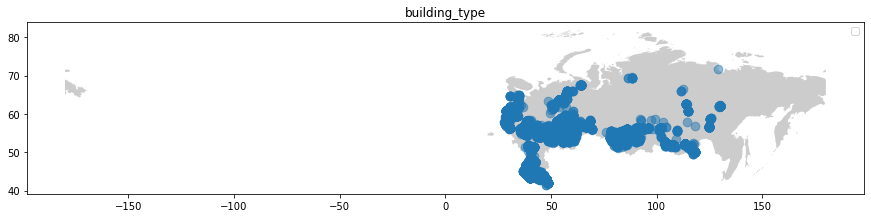

In [301]:
russia_map = gpd.read_file('/Users/karinahanova/Desktop/MTS.Teta/geo_practice/russia_shape_file/RUS_adm0.shp')


geometry = [Point(xy) for xy in zip (data_region_big_info['geo_lon'][:100000], 
                                     data_region_big_info['geo_lat'][:100000])]

crs = {'init': 'epsg:4326'}
geo_data = gpd.GeoDataFrame(data_region_big_info[:100000], crs=crs, geometry=geometry)
geo_data.head()

fig,ax = plt.subplots(figsize = (15,15))
russia_map.plot(ax=ax, alpha = 0.4, color ='grey')
geo_data.geometry.plot(ax = ax, alpha=.5, markersize = 75 )
#geo_data[geo_data['building_type']==2].geometry.plot(marker='o', color = 'red', ax = ax, label = '2', alpha = .5, markersize = 10)


plt.title('building_type')
plt.legend()

# Date

In [64]:
data['date'] = pd.to_datetime(data['date'])

In [65]:
data['date'].nunique()

1075

In [66]:
data['year'] =  pd.DatetimeIndex(data['date']).year

In [67]:
data['year'].value_counts()

2019    2233592
2020    1803180
2018     871296
2021     567027
Name: year, dtype: int64

# Region
тк нам известны широта и долгота, можем определить местонахождение объекта. Из получаемого объекта можно взять разные данные: улицу, район, город, регион, округ. С целью отображения на графике возьмем федеральные округа, т.е. region

In [68]:
# тк в датасете более 5 млн данных с целью оптимизации скрипта, будем вычислять адрес не по точной широте/долготе объекта,
# а по среднему значению для каждого региона. В данном случае нам это подходит, тк нам нужны крупные геоданные, 
# такие как округ/область, так что средняя широта/долгота по каждому объекту как раз даст нам нужный результат 
# при меньших затратах мощностей

lat_lon_data = data.groupby('region')['geo_lat','geo_lon'].mean()
lat_lon_data = lat_lon_data.reset_index()

<ipython-input-68-97ac3fc32866>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  lat_lon_data = data.groupby('region')['geo_lat','geo_lon'].mean()


In [69]:
lat_lon_data.head()

,region,geo_lat,geo_lon
0,3,55.721558,37.577705
1,69,48.533577,132.798120
2,81,55.727234,37.784311
3,821,53.239632,34.294103
4,1010,56.917111,53.266262


In [70]:
latitude = list(map(str, lat_lon_data['geo_lat'].values))
longitude = list(map(str, lat_lon_data['geo_lon'].values))

In [71]:
geolocator = Nominatim(user_agent="geoapiExercises")

In [72]:
def get_location_name(latitude, longitude):
    state = []
    for lat, lon in tqdm(zip(latitude, longitude), total = len(latitude)):
        location = geolocator.reverse(lat+","+lon) # передаем широту/долготу
        address = location.raw['address'] # получаем словать с данными
        state.append(address.get('region', ''))
    
    return state

In [73]:
state = get_location_name(latitude, longitude)

100%|██████████| 84/84 [00:41<00:00,  2.01it/s]


In [74]:
lat_lon_data['state'] = state

In [75]:
lat_lon_data

,region,geo_lat,geo_lon,state
0,3,55.721558,37.577705,Центральный федеральный округ
1,69,48.533577,132.798120,Дальневосточный федеральный округ
2,81,55.727234,37.784311,Центральный федеральный округ
3,821,53.239632,34.294103,Центральный федеральный округ
4,1010,56.917111,53.266262,Приволжский федеральный округ
...,...,...,...,...
79,13919,43.102415,44.640433,Северо-Кавказский федеральный округ
80,14368,68.799398,33.085471,Северо-Западный федеральный округ
81,14880,65.414457,74.315036,Уральский федеральный округ
82,16705,59.634298,150.818491,Дальневосточный федеральный округ


In [103]:
lat_lon_data

,region,geo_lat,geo_lon,state
0,3,55.721558,37.577705,Москва
1,69,48.533577,132.798120,Еврейская автономная область
2,81,55.727234,37.784311,Москва
3,821,53.239632,34.294103,Брянская область
4,1010,56.917111,53.266262,Удмуртия
...,...,...,...,...
79,13919,43.102415,44.640433,Северная Осетия — Алания
80,14368,68.799398,33.085471,Мурманская область
81,14880,65.414457,74.315036,Ямало-Ненецкий автономный округ
82,16705,59.634298,150.818491,Магаданская область


In [76]:
data.shape

(5475095, 14)

In [77]:
data.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1,2018
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1,2018
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1,2018
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11,2018
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1,2018


In [78]:
data_with_regions = data.join(lat_lon_data[['state','region']].set_index('region'), on = 'region')

In [79]:
data_with_regions.shape

(5475095, 15)

In [80]:
data_with_regions.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,state
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1,2018,Северо-Западный федеральный округ
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1,2018,Центральный федеральный округ
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1,2018,Приволжский федеральный округ
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11,2018,Южный федеральный округ
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1,2018,Центральный федеральный округ


In [81]:
data_with_regions[data_with_regions['region'] == 3][:3]

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,state
6,4704280,2018-03-04,12:35:25,55.621097,37.431002,3,2,1,25,1,31.7,6.0,11,2018,Центральный федеральный округ
20,8000000,2018-03-17,06:46:32,55.738876,37.825370,3,1,5,9,2,45.0,6.0,1,2018,Центральный федеральный округ
29,11500000,2018-04-03,17:40:53,55.798921,37.738090,3,1,14,16,3,64.9,8.0,1,2018,Центральный федеральный округ


In [82]:
data[data['region'] == 3][:3]

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year
6,4704280,2018-03-04,12:35:25,55.621097,37.431002,3,2,1,25,1,31.7,6.0,11,2018
20,8000000,2018-03-17,06:46:32,55.738876,37.825370,3,1,5,9,2,45.0,6.0,1,2018
29,11500000,2018-04-03,17:40:53,55.798921,37.738090,3,1,14,16,3,64.9,8.0,1,2018


In [83]:
data_with_regions['state'].nunique()

9

# Quarter 
датасет для теста с семплом по 2 тыс записей за каждый квартал, чтобы посомтреть на графике

In [86]:
data_with_regions['quarter'] = data_with_regions['date'].dt.quarter

In [87]:
data_with_regions.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,state,quarter
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1,2018,Северо-Западный федеральный округ,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1,2018,Центральный федеральный округ,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1,2018,Приволжский федеральный округ,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11,2018,Южный федеральный округ,1
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1,2018,Центральный федеральный округ,1


In [109]:
sample_data = pd.DataFrame()
for year in [2018,2019,2020,2021]:
    for quarter in range(4):
        q = quarter+1
        sub_data = data_with_regions[(data_with_regions['year'] == year) & (data_with_regions['quarter'] == q)]
        if sub_data.shape[0] > 2000:
            sample_data = sample_data.append(sub_data.sample(2000))
        #else:
           # sample_data = sample_data.append(sub_data)

In [110]:
sample_data.shape

(24000, 16)

In [111]:
sample_data.groupby(['year','quarter'])['price'].count()

year  quarter
2018  3          2000
      4          2000
2019  1          2000
      2          2000
      3          2000
      4          2000
2020  1          2000
      2          2000
      3          2000
      4          2000
2021  1          2000
      2          2000
Name: price, dtype: int64

In [112]:
sample_data.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,state,quarter
24642,2300000,2018-09-11,17:31:05,44.831314,37.677041,2843,2,6,6,1,49.0,13.0,1,2018,Южный федеральный округ,3
30113,1400000,2018-09-12,15:38:32,53.398877,58.971952,5282,1,5,5,3,56.0,38.0,1,2018,Уральский федеральный округ,3
92782,1800000,2018-09-19,11:30:54,53.511758,50.268386,3106,1,2,5,3,58.0,6.0,1,2018,Приволжский федеральный округ,3
12834,600000,2018-09-10,10:29:16,47.413348,40.263193,3230,3,1,2,1,21.0,5.0,1,2018,Южный федеральный округ,3
121547,3150000,2018-09-23,13:41:41,55.135109,61.435558,5282,1,10,10,2,67.0,14.0,1,2018,Уральский федеральный округ,3


In [107]:
sample_data[(sample_data['year'] == 2019) | (sample_data['year'] == 2020)]

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,state,quarter
1206326,2915628,2019-02-22,13:07:44,54.734944,55.957847,2722,2,12,25,2,42.4,4.6,11,2019,Приволжский федеральный округ,1
1403634,4450000,2019-03-20,08:54:12,56.818779,60.579920,6171,1,4,5,4,74.0,7.0,1,2019,Уральский федеральный округ,1
1283239,3200000,2019-03-01,11:11:26,53.203239,50.187680,3106,3,3,9,2,48.0,7.8,1,2019,Приволжский федеральный округ,1
931829,2250000,2019-01-15,14:11:26,47.229523,39.594044,3230,1,19,20,1,35.0,9.0,1,2019,Южный федеральный округ,1
1398435,2900000,2019-03-19,14:18:46,47.225590,39.623420,3230,1,4,10,2,57.0,9.0,1,2019,Южный федеральный округ,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4538969,2350000,2020-10-10,18:19:40,45.094033,39.000313,2843,2,2,17,1,40.0,12.0,1,2020,Южный федеральный округ,4
4507984,2857140,2020-10-03,14:26:40,58.010258,56.234203,5520,2,14,19,2,55.6,10.0,11,2020,Приволжский федеральный округ,4
4679518,3400000,2020-11-07,08:31:40,54.992181,82.839137,9654,1,9,9,2,43.0,7.0,1,2020,Сибирский федеральный округ,4
4755812,4090000,2020-11-25,13:53:01,58.010258,56.234203,5520,2,4,24,2,62.0,14.5,11,2020,Приволжский федеральный округ,4


In [115]:
figure = bubbleplot(dataset = sample_data, 
                    x_column='price', y_column='levels', 
                    bubble_column='region', 
                    time_column='year', 
                    size_column='area', 
                    color_column='state', 
    x_title="price", y_title="levels", title ='Изменения цен в зависимости от площади',
    x_logscale = True, scale_bubble=3, height=650)

iplot(figure)

# Baseline 
Будем предсказывать среднее значение по району

In [117]:
data.groupby('region')['price'].mean()

region
3        1.314751e+07
69       2.088702e+06
81       4.766510e+06
821      2.514267e+06
1010     2.335856e+06
             ...     
13919    2.578329e+06
14368    2.283814e+06
14880    3.941868e+06
16705    2.939970e+06
61888    3.820000e+06
Name: price, Length: 84, dtype: float64

In [127]:
data['region'].value_counts()

9654     1048966
2843      637124
81        500221
2661      461564
3         439078
          ...   
16705        139
69            77
4963          65
1901          12
61888          5
Name: region, Length: 84, dtype: int64

In [126]:
len(set(data['region'].values))

84

<AxesSubplot:xlabel='price', ylabel='Count'>

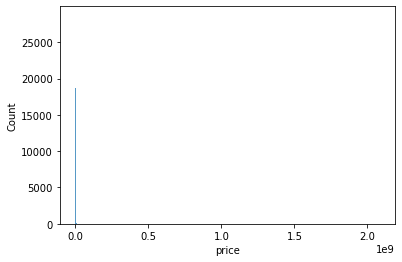

In [133]:
sns.histplot(data = data[data['region'] == 9654], x = 'price')

In [137]:
mean_median_region_price = data.groupby('region')['price'].agg(['mean','median'])
mean_median_region_price = mean_median_region_price.reset_index()

In [139]:
mean_median_region_price['diff'] = mean_median_region_price['mean'] - mean_median_region_price['median']

In [144]:
mean_median_region_price

,region,mean,median,diff
0,3,1.314751e+07,9350000.0,3.797506e+06
1,69,2.088702e+06,2000700.0,8.800208e+04
2,81,4.766510e+06,4300000.0,4.665104e+05
3,821,2.514267e+06,2279200.0,2.350666e+05
4,1010,2.335856e+06,2150000.0,1.858555e+05
...,...,...,...,...
79,13919,2.578329e+06,2250000.0,3.283291e+05
80,14368,2.283814e+06,2150000.0,1.338135e+05
81,14880,3.941868e+06,3500000.0,4.418684e+05
82,16705,2.939970e+06,2500000.0,4.399704e+05


In [142]:
sum(mean_median_region_price['diff'] < 0)

0

<AxesSubplot:>

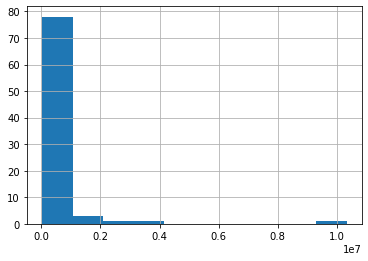

In [145]:
mean_median_region_price['diff'].hist()

Во всех регионах mean > median , значит, для каждого региона свойственна правосторонняя ассиметрия. Для большинаства наблюдений разница между средним значением и медианой небольшое, поэтому при построении бейзлайна будем ориентироваться на среднее значение по регону

In [149]:
data

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1,2018
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1,2018
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1,2018
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11,2018
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5477001,19739760,2021-05-01,20:13:58,55.804736,37.750898,3,1,8,17,4,93.2,13.8,11,2021
5477002,12503160,2021-05-01,20:14:01,55.841415,37.489624,3,2,17,32,2,45.9,6.6,11,2021
5477003,8800000,2021-05-01,20:14:04,56.283909,44.075408,2871,2,4,17,3,86.5,11.8,1,2021
5477004,11831910,2021-05-01,20:14:12,55.804736,37.750898,3,1,8,33,2,52.1,18.9,11,2021


In [165]:
X = data.drop(columns = 'price')
y = data['price']

In [166]:
X.head()

,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year
0,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1,2018
1,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1,2018
2,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1,2018
3,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11,2018
4,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1,2018


In [167]:
print(X.shape)
print(y.shape)

(5475095, 13)
(5475095,)


In [179]:
# split the data on train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, train_size=0.8, 
                                                    random_state=42, shuffle=True)

In [169]:
print(X_train.shape)
print(y_train.shape)

(4380076, 13)
(4380076,)


In [180]:
X_test.head()

,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year
1006840,2019-01-26,12:17:49,56.373325,36.686100,81,3,1,5,2,45.0,6.0,1,2019
774797,2018-12-21,10:59:50,44.674950,37.786890,2843,2,14,16,2,81.0,17.0,1,2018
3887244,2020-06-13,08:55:09,60.071649,30.254798,2661,2,10,25,2,64.5,9.8,11,2020
3503246,2020-03-27,05:51:48,59.900543,30.428158,2661,0,5,18,1,51.2,19.9,11,2020
536995,2018-11-21,18:37:30,55.885397,37.267585,81,2,7,8,2,50.4,8.0,1,2018


In [181]:
y_test[:5]

1006840    2100000
774797     5900000
3887244    3300000
3503246    7062922
536995     5500000
Name: price, dtype: int64

In [204]:
def baseline_model(X_train, X_test, y_train, y_test):
    X_train['price']  = y_train
    mean_price_per_region = X_train.groupby('region')['price'].mean()
    mean_price_per_region = mean_price_per_region.reset_index()
    
    rezult = X_test.join(mean_price_per_region[['price','region']].set_index('region'), on = 'region')
    rezult['price_true'] = y_test
    return rezult

In [205]:
rezult = baseline_model(X_train, X_test, y_train, y_test)

<ipython-input-204-46e76114eb93>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [206]:
rezult

,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,price,price_true
1006840,2019-01-26,12:17:49,56.373325,36.686100,81,3,1,5,2,45.0,6.0,1,2019,4.767964e+06,2100000
774797,2018-12-21,10:59:50,44.674950,37.786890,2843,2,14,16,2,81.0,17.0,1,2018,3.591981e+06,5900000
3887244,2020-06-13,08:55:09,60.071649,30.254798,2661,2,10,25,2,64.5,9.8,11,2020,8.250061e+06,3300000
3503246,2020-03-27,05:51:48,59.900543,30.428158,2661,0,5,18,1,51.2,19.9,11,2020,8.250061e+06,7062922
536995,2018-11-21,18:37:30,55.885397,37.267585,81,2,7,8,2,50.4,8.0,1,2018,4.767964e+06,5500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849879,2020-12-13,12:57:47,59.987210,30.647857,3446,3,5,11,1,37.0,9.5,1,2020,3.861684e+06,3600000
970806,2019-01-22,08:04:25,53.151392,50.074214,3106,3,16,16,1,38.0,9.0,1,2019,2.839927e+06,2250000
3490335,2020-03-26,22:49:42,61.792374,34.346639,8090,3,2,9,3,54.8,6.1,1,2020,2.357094e+06,2700000
3546145,2020-03-30,20:50:01,47.245924,39.689961,3230,2,2,25,1,33.7,9.8,11,2020,2.772603e+06,1685000


In [210]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [209]:
mean_squared_error(y_true=rezult['price_true'], y_pred=rezult['price'].values)

220108136746418.8

In [211]:
mean_absolute_error(y_true=rezult['price_true'], y_pred=rezult['price'].values)

2283446.140243244